<a href="https://colab.research.google.com/github/ua-datalab/Geospatial_Workshops/blob/main/notebooks/detecto_geospatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses **detecto**, a lightweight Python library that will allow us to create a convolutional neural network object detection model in very few lines of code. It downloads a pre-trained Faster R-CNN ResNet50 FPN from Pytorch as the starting point. We then use an existing labeled training dataset to fine-tune the model to identify 10 different objects from aerial imagery.

In [1]:
# install the required libraries to the virtual machine (! indicates install to underlying computer)
!pip install detecto --quiet
!pip install pascal-voc-writer --quiet

The [NWPU VHR-10 dataset](https://github.com/chaozhong2010/VHR-10_dataset_coco) is a very high resolution (VHR) aerial imagery dataset that consists of 800 total images. The dataset has has ten classes of labeled objects: 1. airplane(757), 2. ship(302), 3. storage tank(655), 4. baseball diamond(390), 5. tennis court(524), 6. basketball court(159), 7. ground track field(163), 8. harbor(224), 9. bridges(124), and 10. vehicle(477).

In [16]:
#Download the labeled training data set (NWPU_VHR-10.tar) from github
!wget https://github.com/ua-datalab/Geospatial_Workshops/raw/main/data/NWPU_VHR-10.tar

--2024-08-15 22:20:04--  https://github.com/ua-datalab/Geospatial_Workshops/raw/main/data/NWPU_VHR-10.tar
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/NWPU_VHR-10.tar [following]
--2024-08-15 22:20:05--  https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/NWPU_VHR-10.tar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77957120 (74M) [application/octet-stream]
Saving to: ‘NWPU_VHR-10.tar’

NWPU_VHR-10.tar     100%[===================>]  74.35M   219MB/s    in 0.3s    

2024-08-15 22:20:07 (219 MB/s) - ‘NWPU_VHR-10.tar’ saved [77

The next line of code will decompress the tar file and give you access to the imagery and labels.

Within the root directory (NWPU_VHR-10_dataset), the subdirectory *positive_image_set* has 650 jpg images with each image containing at least one target object. The subdirectory *ground_truth* contains a a text file corresponding to each image. Each line of those text files defines a ground truth bounding box in the following format:
(x1,y1),(x2,y2),a

where (x1,y1) denotes the top-left coordinate of the bounding box, (x2,y2) denotes the right-bottom coordinate of the bounding box, and a is the object class (1-airplane, 2-ship, 3-storage tank, 4-baseball diamond, 5-tennis court, 6-basketball court, 7-ground track field, 8-harbor, 9-bridge, 10-vehicle).

In [17]:
#Decompress the labeled training data tar file
!tar -xvf NWPU_VHR-10.tar

./NWPU_VHR-10_dataset/
./NWPU_VHR-10_dataset/readme.txt
./NWPU_VHR-10_dataset/.ipynb_checkpoints/
./NWPU_VHR-10_dataset/positive_image_set/
./NWPU_VHR-10_dataset/positive_image_set/515.jpg
./NWPU_VHR-10_dataset/positive_image_set/043.jpg
./NWPU_VHR-10_dataset/positive_image_set/450.jpg
./NWPU_VHR-10_dataset/positive_image_set/104.jpg
./NWPU_VHR-10_dataset/positive_image_set/212.jpg
./NWPU_VHR-10_dataset/positive_image_set/110.jpg
./NWPU_VHR-10_dataset/positive_image_set/092.jpg
./NWPU_VHR-10_dataset/positive_image_set/216.jpg
./NWPU_VHR-10_dataset/positive_image_set/195.jpg
./NWPU_VHR-10_dataset/positive_image_set/224.jpg
./NWPU_VHR-10_dataset/positive_image_set/533.jpg
./NWPU_VHR-10_dataset/positive_image_set/559.jpg
./NWPU_VHR-10_dataset/positive_image_set/535.jpg
./NWPU_VHR-10_dataset/positive_image_set/431.jpg
./NWPU_VHR-10_dataset/positive_image_set/052.jpg
./NWPU_VHR-10_dataset/positive_image_set/511.jpg
./NWPU_VHR-10_dataset/positive_image_set/037.jpg
./NWPU_VHR-10_dataset/posit

**detecto** requires that the dataset is labeled in the [Pascal VOC format](http://host.robots.ox.ac.uk/pascal/VOC/). In this dataset, the labels for the images are stored in plain text files, so we will first convert the data to the required format.


In [18]:
#Import the required tools

import os # used for looking through directories
import re # search in strings
from pascal_voc_writer import Writer # create the .xml files with the VOC format
from PIL import Image # used to get height, width of images

In [19]:
# get a list of the text file names
base = './NWPU_VHR-10_dataset'
txt_files = os.listdir(os.path.join(base, 'ground_truth'))

In [20]:
#Create a dictionary that maps the class number to the class name.

classes = {
    1: 'airplane',
    2: 'ship',
    3: 'storage tank',
    4: 'baseball diamond',
    5: 'tennis court',
    6: 'basketball court',
    7: 'ground track field',
    8: 'harbor',
    9: 'bridge',
    10: 'vehicle'
}

print(type(classes))

<class 'dict'>


In [21]:
# loop through each ground truth text file and convert to Pascal VOC format.
# This will create a new xml file for each image and will save it in the directory 'positive_image_set'
for txt in txt_files:
    # open the text file for reading
    with open(os.path.join(base, 'ground_truth', txt), 'r') as reader:

        # locate and open corresponding image
        img_id, _ = txt.split('.')
        img_path = os.path.join(base, 'positive_image_set', f'{img_id}.jpg')
        img = Image.open(img_path)

        # create a writer for the xml file
        xml_path = os.path.join(base, 'positive_image_set', f'{img_id}.xml')
        writer = Writer(img_path, img.width, img.height)

        # convert the text file to an xml file and save
        lines = reader.readlines()
        for line in lines:
            numbers = re.findall(r'\d+', line)
            if not numbers: # skip empty lines
                continue
            xmin, ymin, xmax, ymax, class_id = list(map(int, numbers))
            writer.addObject(classes[class_id], xmin, ymin, xmax, ymax)
        writer.save(xml_path)

Next, we load the 650 images into datasets and ensure that we can access images from that dataset. Because **detecto** is built on top of PyTorch, we will access a method from PyTorch's Dataset to create a random split between training, validation, and test datasets.



In [22]:
from detecto.core import Dataset
import torch
from torch.utils.data import random_split

# this sets the seed of the random generator to ensure reproducibility
random_generator = torch.Generator().manual_seed(42)

# create the datasets
dataset = Dataset(os.path.join(base, 'positive_image_set/'))
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

**detecto** provides a visualization function that will display the image along with bounding boxes and labels for the objects it contains.

/usr/local/lib/python3.10/dist-packages/detecto/core.py:166: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  boxes = torch.tensor(boxes).view(-1, 4)


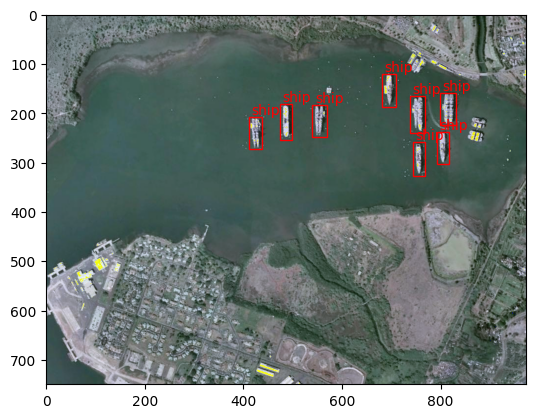

In [23]:
from detecto.visualize import show_labeled_image

# access and show some of the data
image, targets = train_dataset[36]
show_labeled_image(image, targets['boxes'], targets['labels'])

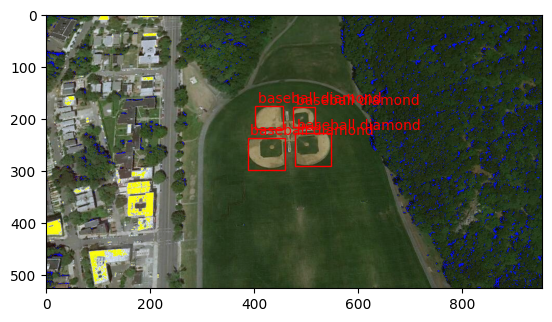

In [24]:
image, targets = val_dataset[1]
show_labeled_image(image, targets['boxes'], targets['labels'])

With the data loaded, we can now train the model. Here, we use a DataLoader to wrap the Dataset object. This allows us to specify the batch size used during each training step, one of a few hyperparameters we can play with during fine tuning.

Note that we are required to tell **detecto** which labels we are interested in learning to identify.

In [25]:
from detecto.core import DataLoader, Model

# wrap the training set in a DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# specify all unique labels you're trying to predict
labels = [
    'airplane',
    'ship',
    'storage tank',
    'baseball diamond',
    'tennis court',
    'basketball court',
    'ground track field',
    'harbor',
    'bridge',
    'vehicle'
]

In [ ]:
# initialize a model with the target labels and fit the model
# This step will take some time and is accelerated with GPU
model = Model(labels)
losses = model.fit(train_loader,
                   val_dataset,
                   epochs=8,
                   lr_step_size=5,
                   learning_rate=0.001,
                   verbose=True)

Here we perform a sanity check to ensure that the training process is working correctly by checking that the loss is decreasing.

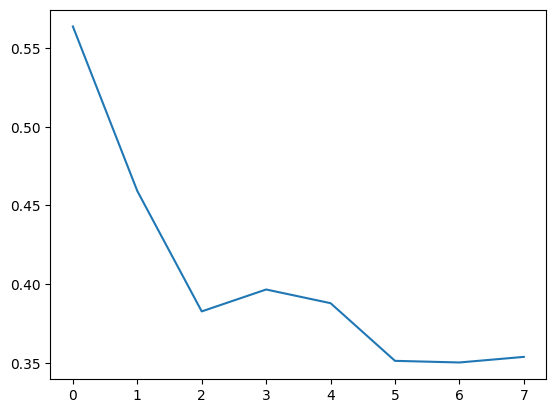

In [ ]:
from matplotlib import pyplot as plt

plt.plot(losses)
plt.show()

In [ ]:
model.save('detecto_vhr_finetune.pth')

If you have computation limitation and want to skip the model training, we can use a pre-trained model that has already been trained on the NWPU-VHR dataset. Download the model from huggingface.

In [2]:
!wget https://huggingface.co/jgillan/detecto_vhr_finetune/resolve/main/detecto_vhr_finetune.pth

--2024-08-15 22:16:18--  https://huggingface.co/jgillan/detecto_vhr_finetune/resolve/main/detecto_vhr_finetune.pth
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.118, 18.164.174.17, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/2a/1b/2a1b5d6471b63cd92461ef557884bccd94e9c0ccc0f6a3aa37af756b838e38fb/528abd6a688d57c2b166157465f52c50f08ff48613b3e09580dbea9bff5c9215?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27detecto_vhr_finetune.pth%3B+filename%3D%22detecto_vhr_finetune.pth%22%3B&Expires=1724019378&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNDAxOTM3OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzJhLzFiLzJhMWI1ZDY0NzFiNjNjZDkyNDYxZWY1NTc4ODRiY2NkOTRlOWMwY2NjMGY2YTNhYTM3YWY3NTZiODM4ZTM4ZmIvNTI4YWJkNmE2ODhkNTdjMmIxNjYxNTc0NjVmNTJjNTBmMDhm

In [26]:
#Load pre-trained model from hugging face
model = Model.load('detecto_vhr_finetune.pth', labels)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 98.1MB/s]


Now that the model is trained, we can run it on a few test images to check the performance. One trade off of using **detecto** is that it does not give you access to the PyTorch methods that allow you to calculate accuracy on the test set, so this will be a qualitative check rather than a quantitative one. If your project requires this, I'd suggest using detecto as a first pass at seeing if this architecture will work for your task, and if so, a second pass using PyTorch is in order.

In [27]:
images = [] #create an empty list
for i in range(4,8): #  create a for loop that will grab 4 images from the validation dataset
    image, _ = val_dataset[i]
    images.append(image)

top_predictions= model.predict_top(images) # Predict objects on the 4 validation images

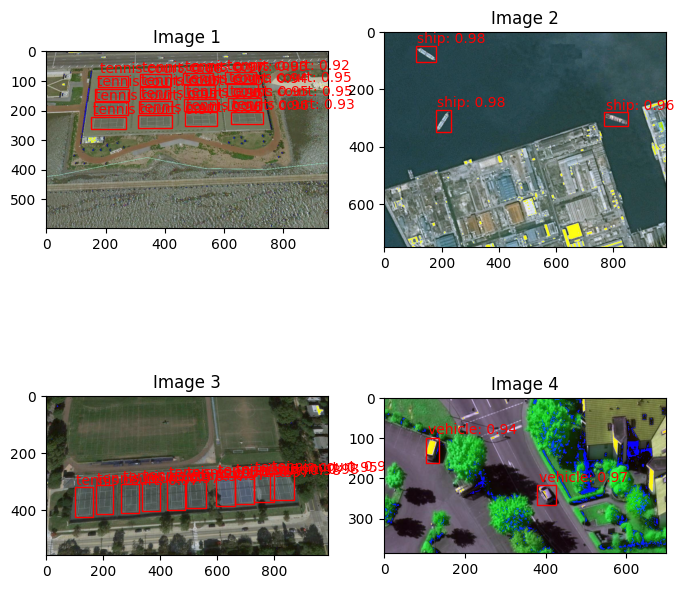

In [28]:
#Display 4 validation images and show the predicted bounding box and label.

from detecto.visualize import plot_prediction_grid

plot_prediction_grid(model, images, dim=(2, 2), figsize=(8, 8))

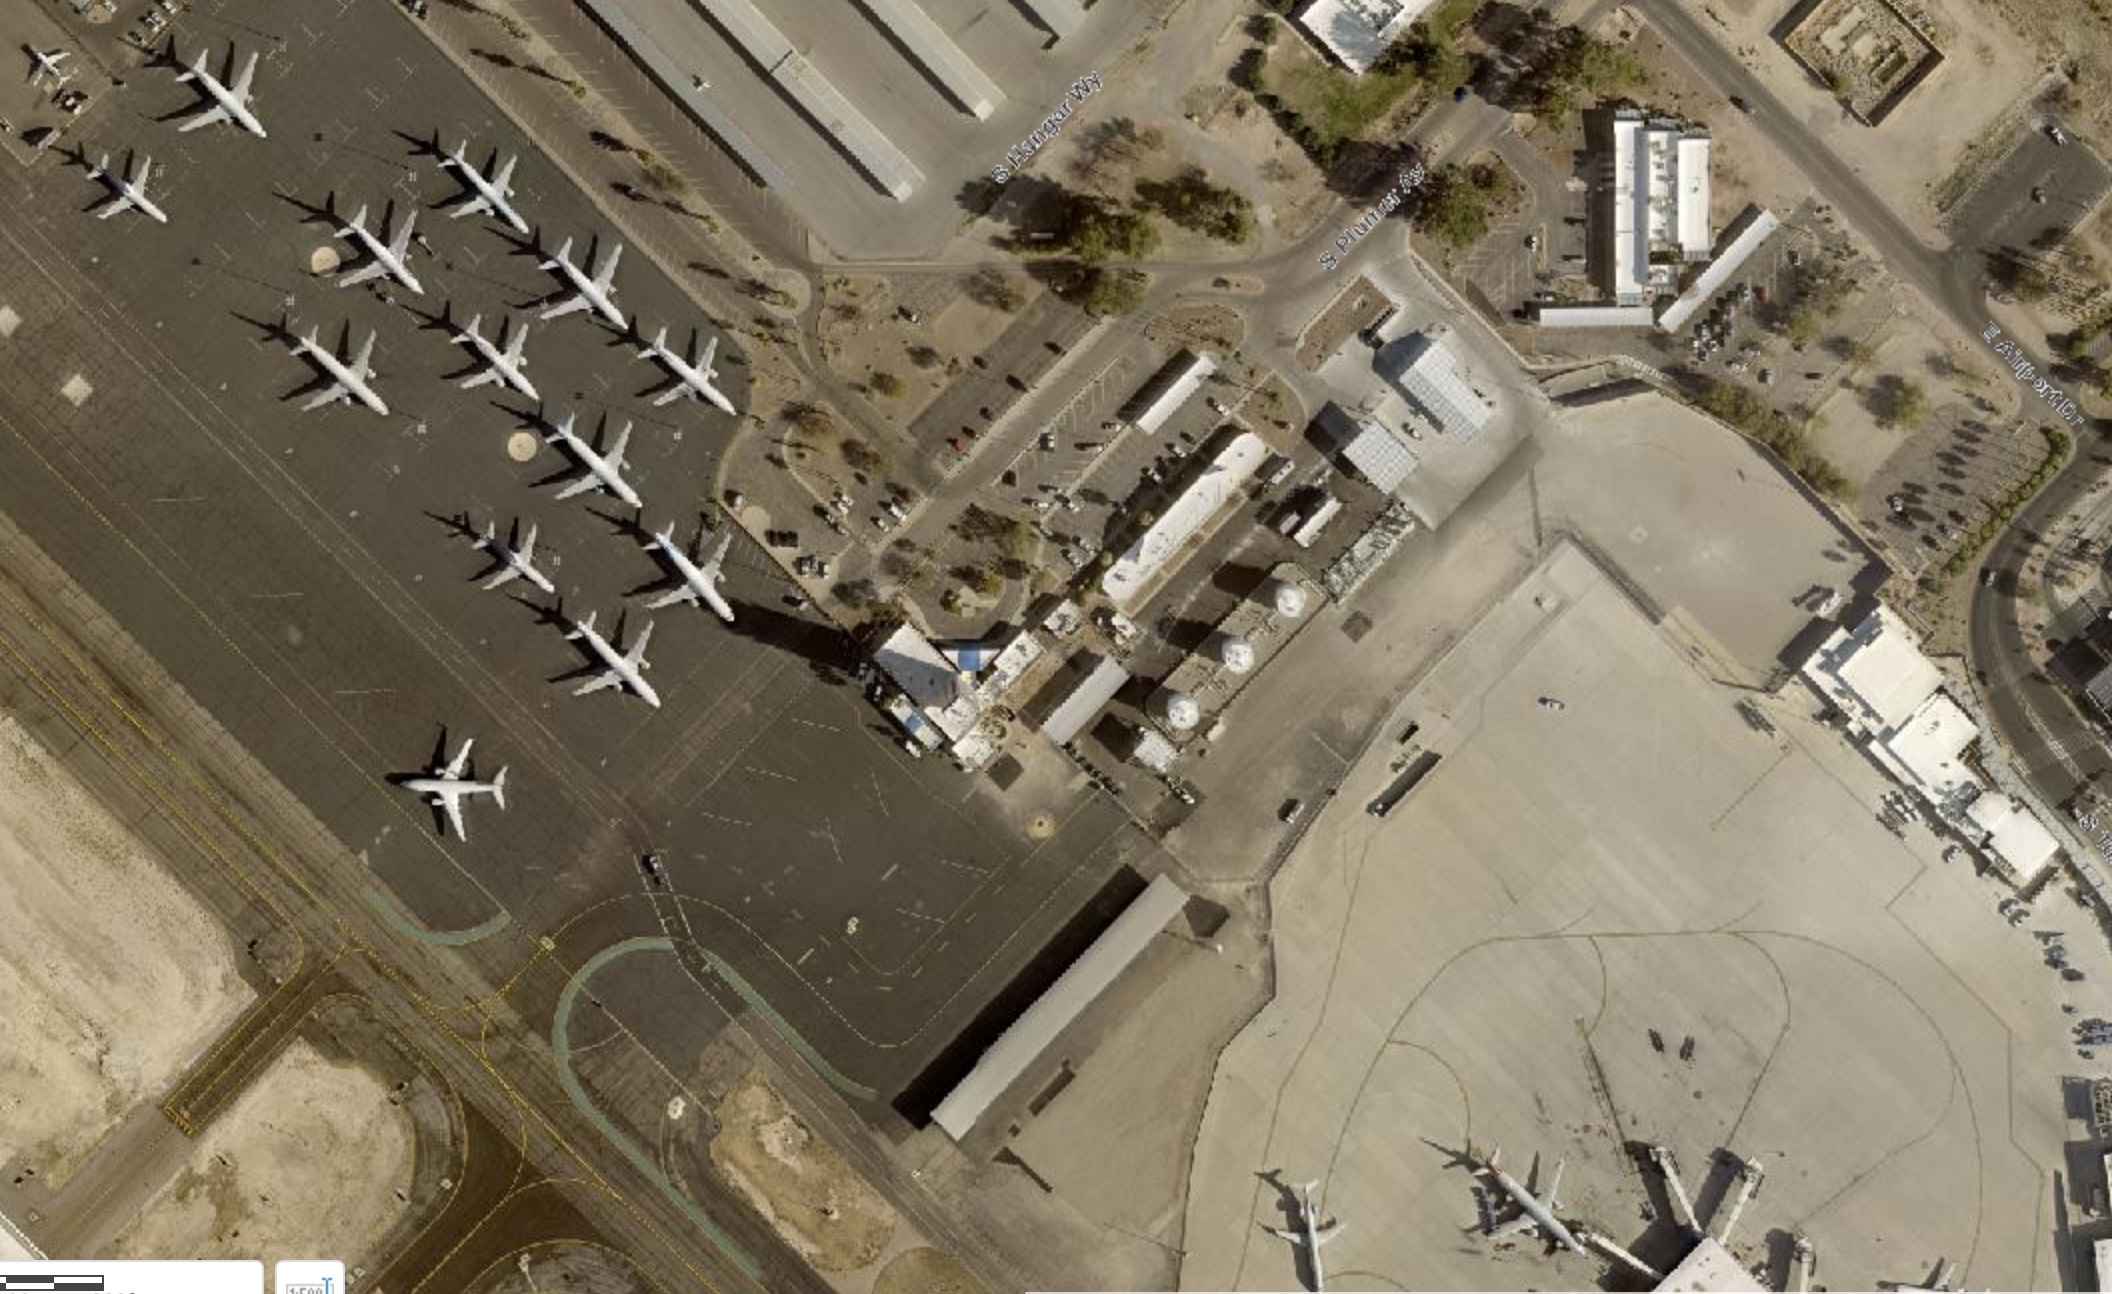

In [ ]:
import urllib.request
from PIL import Image
import IPython.display as display

# Replace the URL with the actual link to your .png file
url = 'https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/airplane_test.png'
urllib.request.urlretrieve(url, 'airplane_test.png')

# Load and display the image
image = Image.open('airplane_test.png')
display.display(image)


--2024-08-15 22:24:03--  https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/airplane_test.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3119258 (3.0M) [image/png]
Saving to: ‘airplane_test.png’

airplane_test.png   100%[===================>]   2.97M  --.-KB/s    in 0.05s   

2024-08-15 22:24:03 (55.8 MB/s) - ‘airplane_test.png’ saved [3119258/3119258]



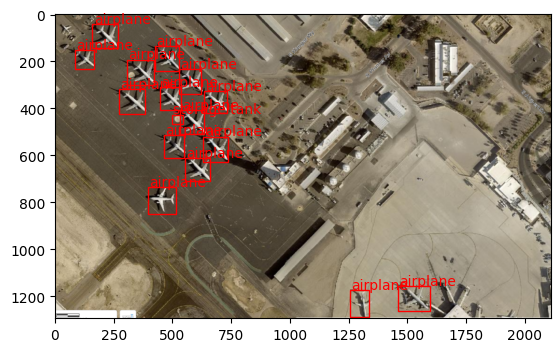

In [29]:
from detecto.core import Model
from detecto.utils import read_image
from detecto.visualize import show_labeled_image


!wget https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/airplane_test.png


image = read_image('airplane_test.png')
labels, boxes, scores = model.predict(image)
show_labeled_image(image, boxes, labels)

--2024-08-15 22:24:24--  https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/vehicle_test2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2200853 (2.1M) [image/png]
Saving to: ‘vehicle_test2.png’

vehicle_test2.png   100%[===================>]   2.10M  --.-KB/s    in 0.05s   

2024-08-15 22:24:24 (39.2 MB/s) - ‘vehicle_test2.png’ saved [2200853/2200853]



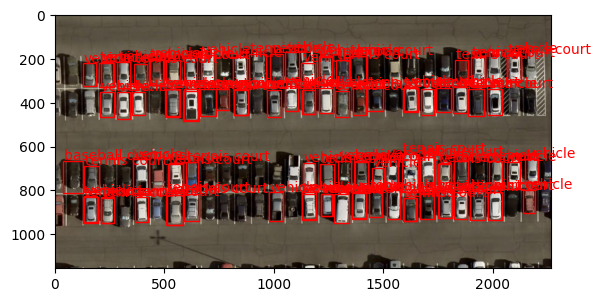

In [30]:
!wget https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/vehicle_test2.png

image = read_image('vehicle_test2.png')
labels, boxes, scores = model.predict(image)
show_labeled_image(image, boxes, labels)

--2024-08-15 22:24:44--  https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/baseball_field_test.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3431791 (3.3M) [image/png]
Saving to: ‘baseball_field_test.png’

baseball_field_test 100%[===================>]   3.27M  --.-KB/s    in 0.06s   

2024-08-15 22:24:45 (57.8 MB/s) - ‘baseball_field_test.png’ saved [3431791/3431791]



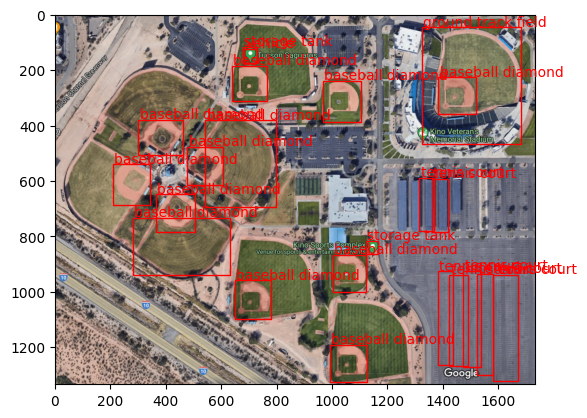

In [31]:
!wget https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/baseball_field_test.png

image = read_image('baseball_field_test.png')
labels, boxes, scores = model.predict(image)
show_labeled_image(image, boxes, labels)